In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import shutil
import pathlib
import itertools
import cv2

from PIL import Image


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, GaussianNoise, Input, MultiHeadAttention, Reshape
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import warnings
warnings.filterwarnings("ignore")

print ('Check')

Check


In [3]:
for dirname, _, filenames in os.walk('parkinson'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

parkinson\drawings\spiral\testing\healthy\V01HE01.png
parkinson\drawings\spiral\testing\healthy\V02HE01.png
parkinson\drawings\spiral\testing\healthy\V03HE1.png
parkinson\drawings\spiral\testing\healthy\V04HE01.png
parkinson\drawings\spiral\testing\healthy\V05HE01.png
parkinson\drawings\spiral\testing\healthy\V06HE01.png
parkinson\drawings\spiral\testing\healthy\V07HE01.png
parkinson\drawings\spiral\testing\healthy\V08HE01.png
parkinson\drawings\spiral\testing\healthy\V09HE01.png
parkinson\drawings\spiral\testing\healthy\V10HE01.png
parkinson\drawings\spiral\testing\healthy\V11HE01.png
parkinson\drawings\spiral\testing\healthy\V55HE12.png
parkinson\drawings\spiral\testing\healthy\V55HE13.png
parkinson\drawings\spiral\testing\healthy\V55HE14.png
parkinson\drawings\spiral\testing\healthy\V55HE15.png
parkinson\drawings\spiral\testing\parkinson\V01PE01.png
parkinson\drawings\spiral\testing\parkinson\V02PE01.png
parkinson\drawings\spiral\testing\parkinson\V03PE01.png
parkinson\drawings\spir

In [4]:
healthy_path = 'parkinson/drawings/spiral/training/healthy'
parkinson_path = 'parkinson/drawings/spiral/training/parkinson'

In [5]:
data = []

for file in os.listdir(healthy_path):
    if file.endswith(".png") or file.endswith(".jpg"): 
        data.append([os.path.join(healthy_path, file), 'healthy'])

for file in os.listdir(parkinson_path):
    if file.endswith(".png") or file.endswith(".jpg"):
        data.append([os.path.join(parkinson_path, file), 'parkinson'])

df = pd.DataFrame(data, columns=['file_path', 'label'])

In [6]:
df.head()

,file_path,label
0,parkinson/drawings/spiral/training/healthy\V01...,healthy
1,parkinson/drawings/spiral/training/healthy\V01...,healthy
2,parkinson/drawings/spiral/training/healthy\V02...,healthy
3,parkinson/drawings/spiral/training/healthy\V02...,healthy
4,parkinson/drawings/spiral/training/healthy\V03...,healthy


In [7]:
df.tail()

,file_path,label
67,parkinson/drawings/spiral/training/parkinson\V...,parkinson
68,parkinson/drawings/spiral/training/parkinson\V...,parkinson
69,parkinson/drawings/spiral/training/parkinson\V...,parkinson
70,parkinson/drawings/spiral/training/parkinson\V...,parkinson
71,parkinson/drawings/spiral/training/parkinson\V...,parkinson


In [8]:
df.shape

(72, 2)

In [9]:
df.columns

Index(['file_path', 'label'], dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  72 non-null     object
 1   label      72 non-null     object
dtypes: object(2)
memory usage: 1.3+ KB


In [11]:
df.nunique()

file_path    72
label         2
dtype: int64

In [12]:
df['label'].unique()

array(['healthy', 'parkinson'], dtype=object)

In [13]:
df['label'].value_counts()

label
healthy      36
parkinson    36
Name: count, dtype: int64

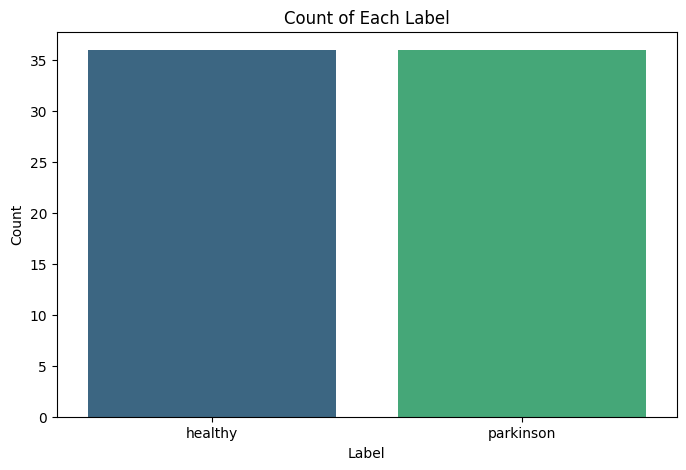

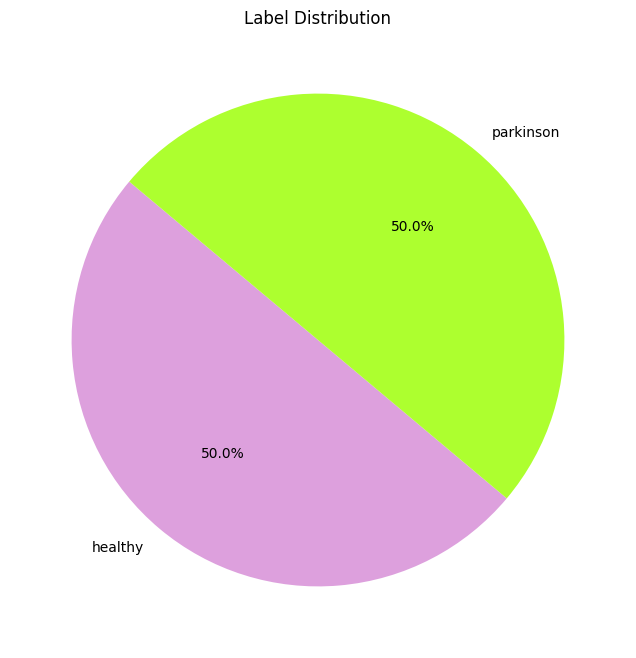

In [14]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='label', palette='viridis')
plt.title("Count of Each Label")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 8))
df['label'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors=['plum', 'greenyellow'])
plt.title("Label Distribution")
plt.ylabel("")
plt.show()

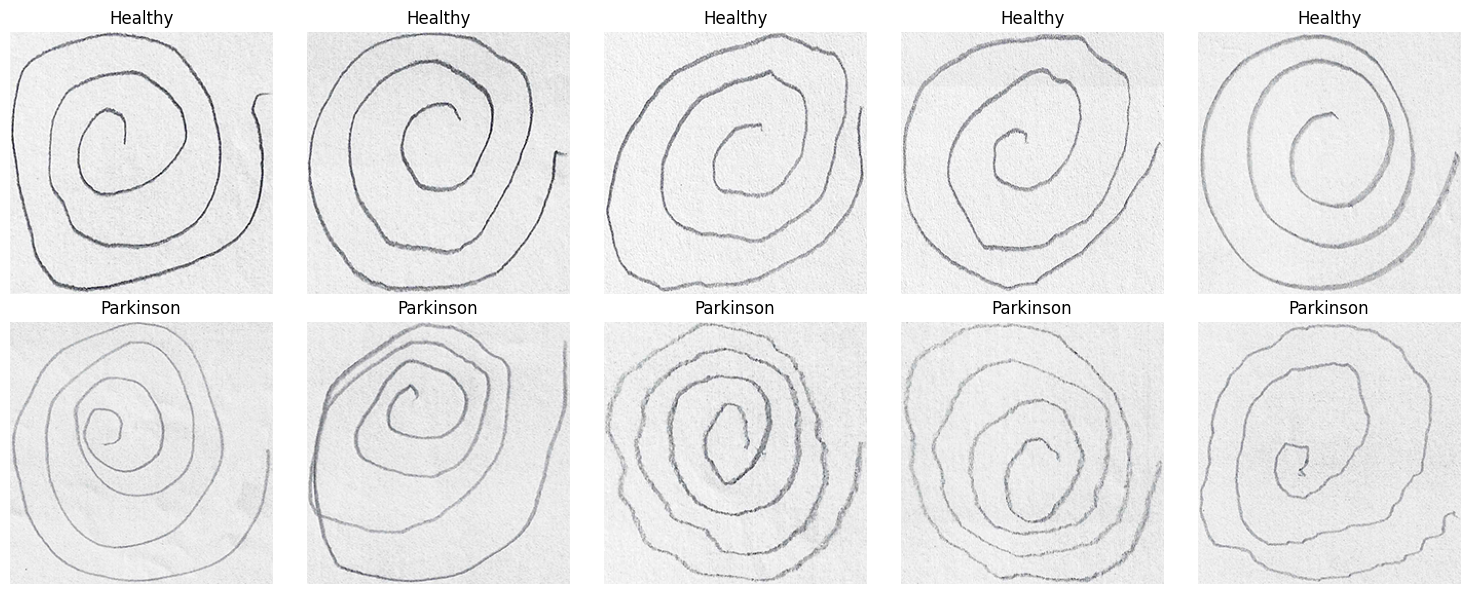

In [15]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    img_healthy = Image.open(df[df['label'] == 'healthy'].iloc[i]['file_path'])
    axes[0, i].imshow(img_healthy, cmap='gray')
    axes[0, i].set_title("Healthy")
    axes[0, i].axis('off')
    
    img_parkinson = Image.open(df[df['label'] == 'parkinson'].iloc[i]['file_path'])
    axes[1, i].imshow(img_parkinson, cmap='gray')
    axes[1, i].set_title("Parkinson")
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

In [16]:
sns.set_style('darkgrid')

In [17]:
train_df_new, temp_df_new = train_test_split(
    df,
    train_size=0.8,  
    shuffle=True,
    random_state=42,
    stratify=df['label']  
)

valid_df_new, test_df_new = train_test_split(
    temp_df_new,
    test_size=0.5,  
    shuffle=True,
    random_state=42,
    stratify=temp_df_new['label'] 
)

In [18]:
batch_size = 16
img_size = (224, 224)
channels = 3 
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1./255)  
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new,
    x_col='file_path',  
    y_col='label',     
    target_size=img_size,
    class_mode='binary',  
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col='file_path',  
    y_col='label',     
    target_size=img_size,
    class_mode='binary',  
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col='file_path', 
    y_col='label',    
    target_size=img_size,
    class_mode='binary',  
    color_mode='rgb', 
    shuffle=False,  
    batch_size=batch_size
)

Found 57 validated image filenames belonging to 2 classes.
Found 7 validated image filenames belonging to 2 classes.
Found 8 validated image filenames belonging to 2 classes.


In [19]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU")
else:
    print("Using CPU")

Using CPU


In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [21]:
def create_inception_model(input_shape):
    
    inputs = Input(shape=input_shape)

    base_model = InceptionV3(weights='imagenet', input_tensor=inputs, include_top=False)
    
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output

    height, width, channels = 5, 5, 2048  
    x = Reshape((height * width, channels))(x) 

    attention_output = MultiHeadAttention(num_heads=8, key_dim=channels)(x, x)  

    attention_output = Reshape((height, width, channels))(attention_output)
    
    x = GaussianNoise(0.25)(attention_output)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.25)(x)
    x = Dropout(0.25)(x)
    outputs = Dense(1, activation='sigmoid')(x)  

    model = Model(inputs=inputs, outputs=outputs)

    return model

input_shape = (224, 224, 3)
cnn_model = create_inception_model(input_shape)

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [22]:
history = cnn_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=10,  
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - accuracy: 0.6235 - loss: 0.9981 - val_accuracy: 0.5714 - val_loss: 0.9488
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.8960 - loss: 0.2167 - val_accuracy: 0.5714 - val_loss: 0.9168
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.9454 - loss: 0.2053 - val_accuracy: 0.7143 - val_loss: 0.8267
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.9860 - loss: 0.1124 - val_accuracy: 0.7143 - val_loss: 1.1137
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.8736 - loss: 0.2214 - val_accuracy: 0.5714 - val_loss: 1.6396
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 1.0000 - loss: 0.0472 - val_accuracy: 0.5714 - val_loss: 2.6159
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9860 - loss: 0.0738 - val_accuracy: 0.5714 - val_loss: 3.7240
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.9881 - loss: 0.0212 - val_accuracy: 0.5714 - val_loss: 4.6535


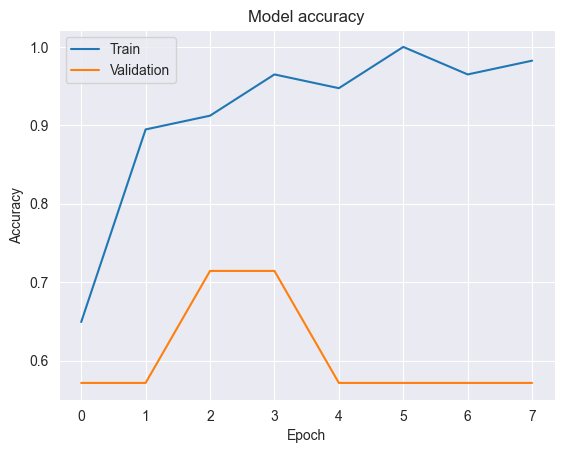

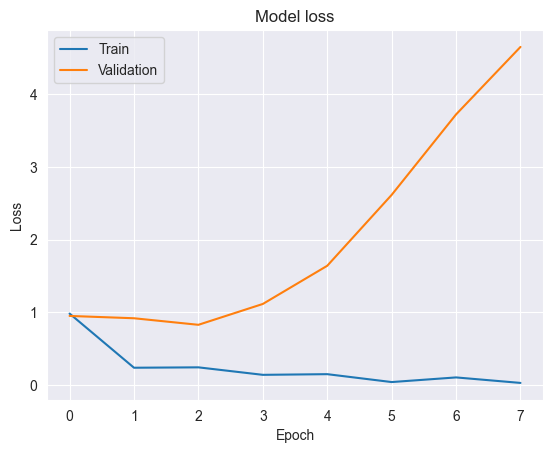

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [24]:
test_labels = test_gen_new.classes  
predictions = cnn_model.predict(test_gen_new)  
predicted_labels = (predictions > 0.5).astype(int).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [25]:
report = classification_report(test_labels, predicted_labels, target_names=list(test_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

     healthy       0.67      1.00      0.80         4
   parkinson       1.00      0.50      0.67         4

    accuracy                           0.75         8
   macro avg       0.83      0.75      0.73         8
weighted avg       0.83      0.75      0.73         8



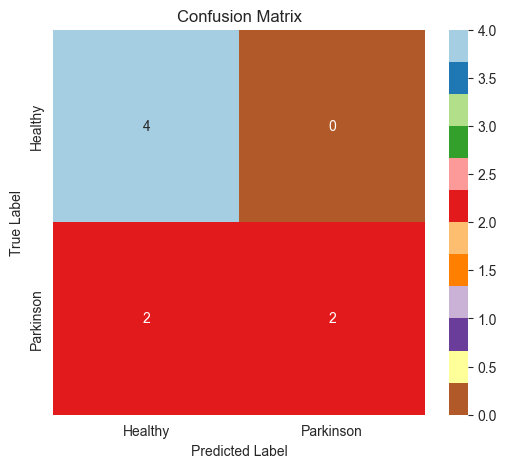

In [26]:
conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Paired_r', xticklabels=['Healthy', 'Parkinson'], yticklabels=['Healthy', 'Parkinson'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [27]:
def create_xception_model(input_shape):
    
    inputs = Input(shape=input_shape)
    
    base_model = Xception(weights='imagenet', input_tensor=inputs, include_top=False)
    
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output

    height, width, channels = 7, 7, 2048  
    x = Reshape((height * width, channels))(x)  
   
    attention_output = MultiHeadAttention(num_heads=8, key_dim=channels)(x, x) 

    attention_output = Reshape((height, width, channels))(attention_output)
    
    x = GaussianNoise(0.25)(attention_output)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.25)(x)
    x = Dropout(0.25)(x)
    outputs = Dense(1, activation='sigmoid')(x)  

    model = Model(inputs=inputs, outputs=outputs)

    return model

input_shape = (224, 224, 3)
cnn_model = create_xception_model(input_shape)

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [28]:
history = cnn_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=10,  
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.7397 - loss: 0.6941 - val_accuracy: 0.7143 - val_loss: 0.6215
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.8507 - loss: 0.3133 - val_accuracy: 0.7143 - val_loss: 0.6315
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.8256 - loss: 0.3364 - val_accuracy: 0.5714 - val_loss: 0.5946
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.9179 - loss: 0.2263 - val_accuracy: 0.7143 - val_loss: 0.5563
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.9526 - loss: 0.1410 - val_accuracy: 0.7143 - val_loss: 0.5790
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - accuracy: 0.9811 - loss: 0.1126 - val_accuracy: 0.5714 - val_loss: 0.5879
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.9701 - loss: 0.1281 - val_accuracy: 0.4286 - val_loss: 0.5907
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.9630 - loss: 0.1372 - val_accuracy: 0.7143 - val_loss: 0.5504
Epoch 9/

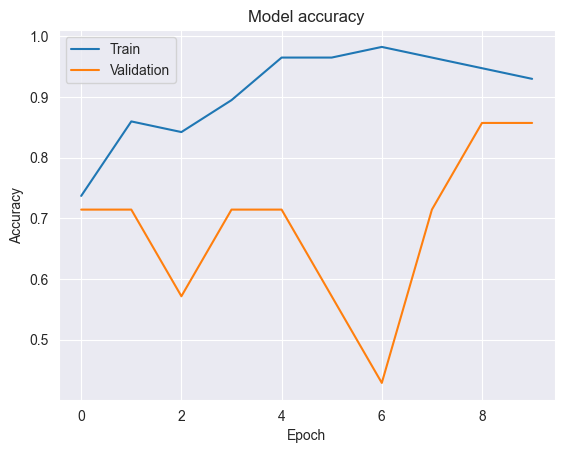

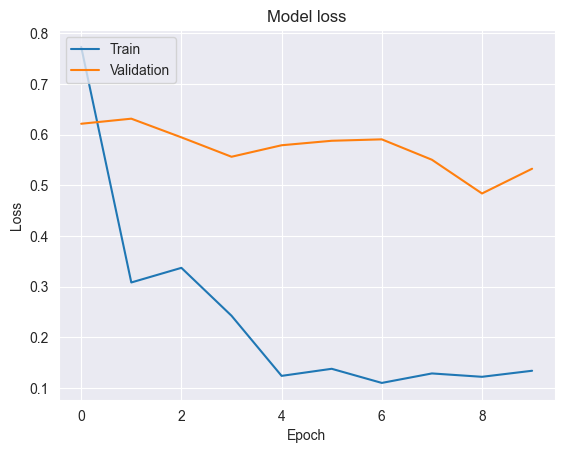

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [30]:
test_labels = test_gen_new.classes  
predictions = cnn_model.predict(test_gen_new)  
predicted_labels = (predictions > 0.5).astype(int).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [31]:
from sklearn.metrics import classification_report

report = classification_report(test_labels, predicted_labels, target_names=list(test_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

     healthy       0.75      0.75      0.75         4
   parkinson       0.75      0.75      0.75         4

    accuracy                           0.75         8
   macro avg       0.75      0.75      0.75         8
weighted avg       0.75      0.75      0.75         8



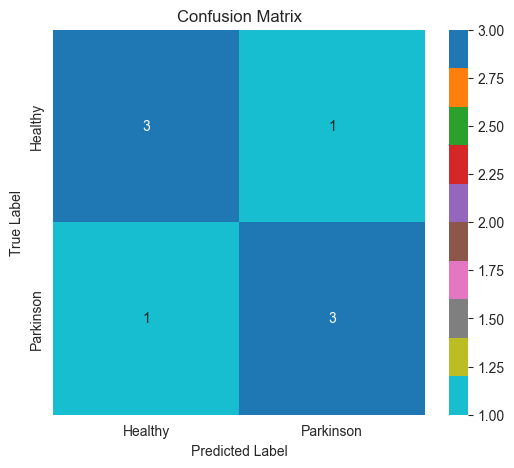

In [32]:
conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='tab10_r', xticklabels=['Healthy', 'Parkinson'], yticklabels=['Healthy', 'Parkinson'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

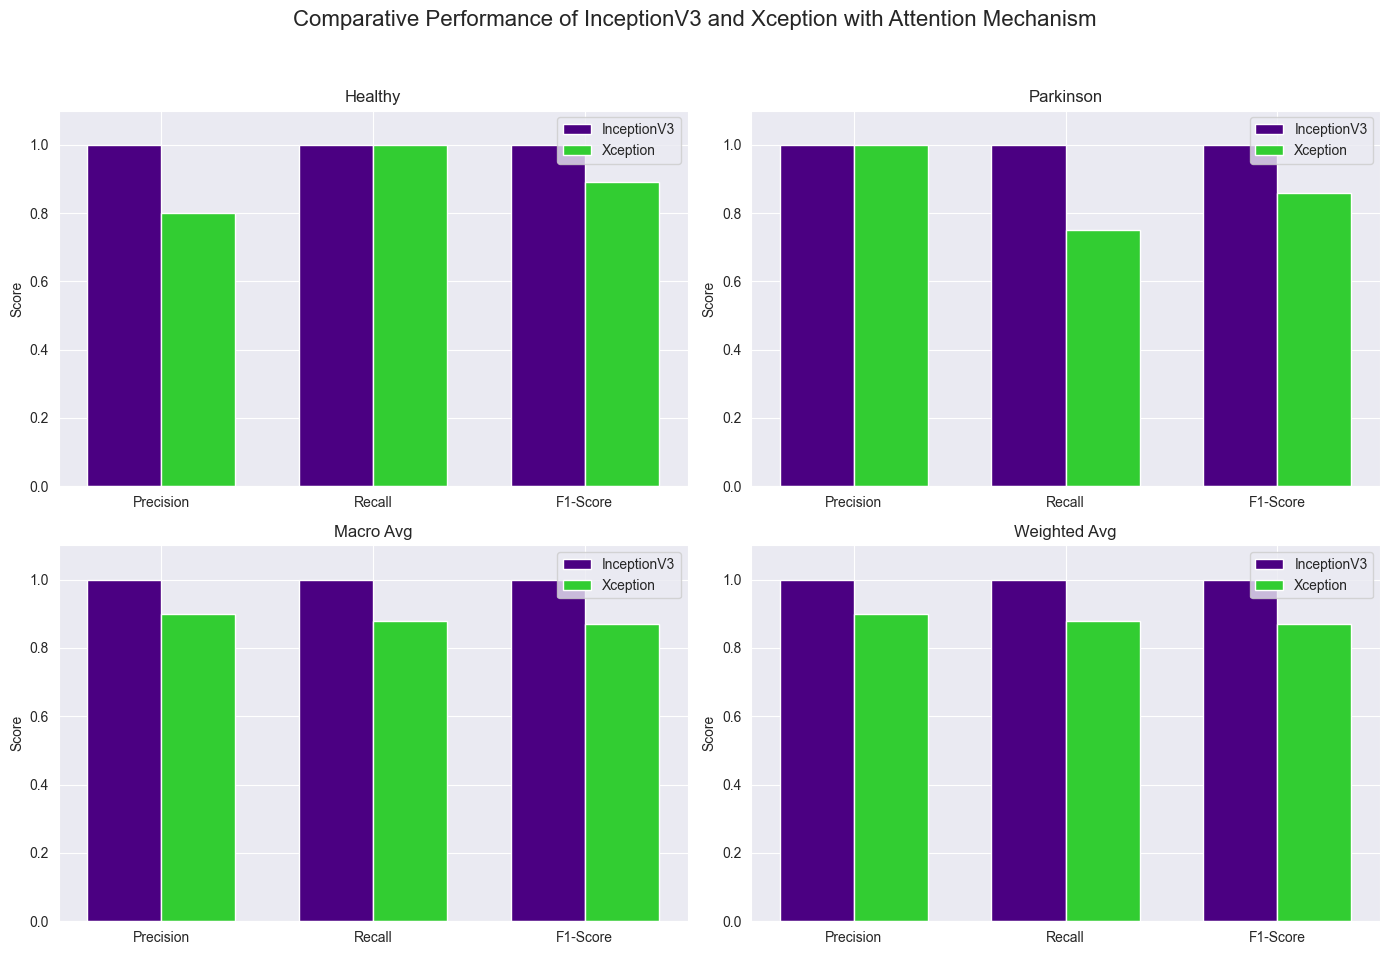

In [33]:
metrics = ["Precision", "Recall", "F1-Score"]
labels = ["Healthy", "Parkinson", "Macro Avg", "Weighted Avg"]

inceptionv3_scores = {
    "Healthy": [1.00, 1.00, 1.00],
    "Parkinson": [1.00, 1.00, 1.00],
    "Macro Avg": [1.00, 1.00, 1.00],
    "Weighted Avg": [1.00, 1.00, 1.00]
}

xception_scores = {
    "Healthy": [0.80, 1.00, 0.89],
    "Parkinson": [1.00, 0.75, 0.86],
    "Macro Avg": [0.90, 0.88, 0.87],
    "Weighted Avg": [0.90, 0.88, 0.87]
}

x = np.arange(len(metrics))  
width = 0.35  

fig, ax = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Comparative Performance of InceptionV3 and Xception with Attention Mechanism", fontsize=16)

for i, label in enumerate(labels):
    row, col = divmod(i, 2)
    ax[row, col].bar(x - width / 2, inceptionv3_scores[label], width, label="InceptionV3", color='indigo')
    ax[row, col].bar(x + width / 2, xception_scores[label], width, label="Xception", color='limegreen')
    ax[row, col].set_title(label)
    ax[row, col].set_xticks(x)
    ax[row, col].set_xticklabels(metrics)
    ax[row, col].set_ylim([0, 1.1])
    ax[row, col].legend()
    ax[row, col].set_ylabel("Score")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()

# Thanks !!!